In [1]:
import os
os.chdir('..')
os.getcwd()

'/Users/signapoop/Desktop/fyp-graph-clustering'

In [2]:
import pickle 
import numpy as np
import torch
import os

In [3]:
from core.DataEmbeddingGraph import DataEmbeddingGraph
from core.EmbeddingDataSet import EmbeddingDataSet

In [4]:
dataset_name = 'cora'
parent_dir = os.path.abspath('..')
input_dir = os.path.join(parent_dir, 'data')
dataset = EmbeddingDataSet(dataset_name, input_dir)
dataset.create_all_data(split_batches=False, shuffle=True)
dataset.summarise()

Name of dataset = cora
Input dimension = 1433
Number of training samples = None
Training labels = True
Graph information = True


In [5]:
G = dataset.all_data[0]

In [6]:
len(G.labels)

2708

In [7]:
G.adj_matrix

<2708x2708 sparse matrix of type '<class 'numpy.int64'>'
	with 10556 stored elements in COOrdinate format>

In [8]:
D = np.sum(G.adj_matrix.toarray(), axis=1)

In [9]:
# Average degree
np.average(D)

3.8980797636632203

In [10]:
import matplotlib.pyplot as plt

(array([2.586e+03, 9.000e+01, 1.600e+01, 8.000e+00, 3.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([  1.  ,   9.35,  17.7 ,  26.05,  34.4 ,  42.75,  51.1 ,  59.45,
         67.8 ,  76.15,  84.5 ,  92.85, 101.2 , 109.55, 117.9 , 126.25,
        134.6 , 142.95, 151.3 , 159.65, 168.  ]),
 <a list of 20 Patch objects>)

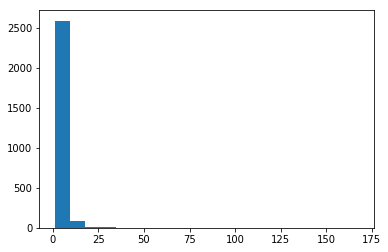

In [11]:
plt.hist(D, bins=20)

In [12]:
from scipy.sparse.csgraph import connected_components
from sklearn.manifold.spectral_embedding_ import _graph_connected_component

In [13]:
n_connected, _ = connected_components(G.adj_matrix)
n_connected

78

In [14]:
foo = _graph_connected_component(G.adj_matrix, 0)
foo.sum()

2485

In [15]:
foo

array([ True,  True,  True, ...,  True,  True,  True])

In [16]:
n = len(G.labels)
visited = np.zeros((n,), dtype=bool)
component_sizes = []
for i in range(n):
    if not visited[i]:
        visited[i] = True
        mask = _graph_connected_component(G.adj_matrix, i)
        component_sizes.append(mask.sum())
        visited = np.logical_or(visited, mask)

In [17]:
# The largest connected component has size 2,485 and is reachable from node 0
print(len(component_sizes))
print(max(component_sizes))

78
2485


In [18]:
component_mask = _graph_connected_component(G.adj_matrix, 0)

In [19]:
all_indices = np.arange(0, n)
mask_indices = [all_indices[i] for i in range(n) if component_mask[i]]

In [20]:
len(mask_indices)

2485

In [22]:
X = G.data[mask_indices]
labels = G.labels[mask_indices]
W = G.adj_matrix.toarray()[mask_indices,:][:,mask_indices]

In [23]:
W.shape

(2485, 2485)

In [24]:
np.count_nonzero(W)

10138

In [25]:
from sklearn.manifold import SpectralEmbedding
embedding = SpectralEmbedding(n_components=2, affinity='precomputed')
X_spectral = embedding.fit_transform(W)

In [26]:
from util.plot_bokeh_embedding import plot_embedding
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [27]:
labels = [int(l) for l in labels]
target_names = [str(i) for i in range(7)]
named_labels = [target_names[l] for l in labels]

In [28]:
plot_embedding(X_spectral, labels, named_labels)

In [29]:
from sklearn.metrics.pairwise import pairwise_distances
D = pairwise_distances(X, metric='cosine')

In [30]:
D.shape

(2485, 2485)

In [31]:
beta = 0
affinity_matrix = 1 - D
affinity_matrix = affinity_matrix + beta * affinity_matrix * W

In [32]:
affinity_matrix.sum()

353406.84640443325

In [33]:
(1-D).sum()

353406.66

In [34]:
from sklearn.manifold import SpectralEmbedding
embedding = SpectralEmbedding(n_components=2, affinity='precomputed')
X_spectral = embedding.fit_transform(affinity_matrix)
plot_embedding(X_spectral, labels, named_labels)

In [62]:
D = pairwise_distances(X, metric='cosine')
beta = 0.7
affinity_matrix = beta * W * D
D = D - affinity_matrix

In [63]:
D

array([[0.        , 1.        , 1.        , ..., 0.89459074, 1.        ,
        0.9057191 ],
       [1.        , 0.        , 0.95554459, ..., 0.95337474, 0.94942784,
        0.95829713],
       [1.        , 0.95554459, 0.        , ..., 0.85698062, 0.89658248,
        0.95735985],
       ...,
       [0.89459074, 0.95337474, 0.85698062, ..., 0.        , 0.78306955,
        0.95527864],
       [1.        , 0.94942784, 0.89658248, ..., 0.78306955, 0.        ,
        1.        ],
       [0.9057191 , 0.95829713, 0.95735985, ..., 0.95527864, 1.        ,
        0.        ]])

In [65]:
from sklearn.manifold import TSNE
embedder = TSNE(n_components=2, metric='precomputed', perplexity=30, verbose=0)
X_emb = embedder.fit_transform(D)

In [66]:
plot_embedding(X_emb, labels, named_labels)

In [69]:
X_emb_graph = X_emb

In [71]:
import scipy.sparse as sp
import bokeh.plotting as bp
from bokeh.plotting import show
from bokeh.models.glyphs import Segment
from bokeh.io import output_notebook
output_notebook()

X_emb = X_emb_graph
labels = np.array(labels)
target_names = [str(i) for i in range(7)]
named_labels = [target_names[l] for l in labels]
adj = sp.coo_matrix(W)  # sparse matrix

# 20 colors
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5"
])

plot_fig = bp.figure(plot_width=900, plot_height=650,
                     tools="pan, wheel_zoom, box_zoom, reset, previewsave",
                     x_axis_type=None, y_axis_type=None, min_border=1)

data_dict = {'x': X_emb[:, 0],
             'y': X_emb[:, 1],
             'color': colormap[labels],
             'label': named_labels}

mySource = bp.ColumnDataSource(data_dict)

classA = labels[adj.row]
classB = labels[adj.col]
mask = classA==classB
edge_colormask = mask * (classA + 1) - 1

#edge_colormask = edge_colormask[mask]
#p0 = X_emb[adj.row[mask],:]
#p1 = X_emb[adj.col[mask],:]

p0 = X_emb[adj.row,:]
p1 = X_emb[adj.col,:]

source = bp.ColumnDataSource(dict(
        x0=p0[:,0],
        y0=p0[:,1],
        x1=p1[:,0],
        y1=p1[:,1],
        color=colormap[edge_colormask]
    )
)

glyph = Segment(x0="x0", y0="y0", x1="x1", y1="y1", line_color="color", line_width=1, line_alpha=0.1)
plot_fig.add_glyph(source, glyph)

plot_fig.circle(x='x', y='y', color='color', legend='label', source=mySource)
plot_fig.legend.location = (0, 70)
new_legend = plot_fig.legend[0]
plot_fig.legend[0].plot = None
plot_fig.add_layout(new_legend, 'right')
plot_fig.legend.label_text_font_size = '7pt'

show(plot_fig)


Loading BokehJS ...

In [68]:
D = pairwise_distances(X, metric='cosine')
embedder = TSNE(n_components=2, metric='precomputed', perplexity=30, verbose=0)
X_emb_features = embedder.fit_transform(D)
plot_embedding(X_emb_features, labels, named_labels)

In [284]:
X_spectral_mix = X_spectral

In [233]:
X_spectral_graph = X_spectral

In [72]:
import networkx as nx

In [73]:
G = nx.from_numpy_matrix(W)

In [74]:
path_lengths = dict(nx.all_pairs_shortest_path_length(G))

In [75]:
def graph_trustworthiness(path_lengths, X_emb, n_neighbors=5):
    dist_X_emb = pairwise_distances(X_emb, squared=True)
    ind_X_emb = np.argsort(dist_X_emb, axis=1)[:, 1:n_neighbors + 1]
    
    n_samples = X.shape[0]
    t = 0.0
    min_sum = 0.0
    max_sum = 0.0
    ranks = np.zeros(n_neighbors)
    for i in range(n_samples):
        for j in range(n_neighbors):
            ranks[j] = path_lengths[i][ind_X_emb[i, j]]
        t += np.sum(ranks)
        lengths_from_i = sorted(list(path_lengths[i].values()))
        min_sum += sum(lengths_from_i[:n_neighbors])
        max_sum += sum(lengths_from_i[-n_neighbors:])
    t = 1.0 - (t-min_sum)/(max_sum-min_sum)
    return t

In [276]:
graph_trustworthiness(path_lengths, X_spectral_graph, n_neighbors=3)

0.5565494573369805

In [277]:
graph_trustworthiness(path_lengths, X_spectral, n_neighbors=3)

0.5518838789376158

In [76]:
X_random = np.random.rand(X_spectral.shape[0], X_spectral.shape[1])

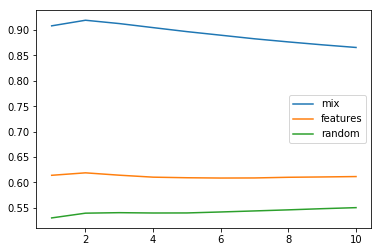

In [78]:
test_range = list(range(1, 11))
y_1 = np.zeros(len(test_range))
y_2 = np.zeros(len(test_range))
y_3 = np.zeros(len(test_range))
y_random = np.zeros(len(test_range))
for i, k in enumerate(test_range):
    y_1[i] = graph_trustworthiness(path_lengths, X_spectral, n_neighbors=k)
    y_2[i] = graph_trustworthiness(path_lengths, X_emb_graph, n_neighbors=k)
    y_3[i] = graph_trustworthiness(path_lengths, X_emb_features, n_neighbors=k)
    y_random[i] = graph_trustworthiness(path_lengths, X_random, n_neighbors=k)

#plt.plot(test_range, y_1, label='spectral')
plt.plot(test_range, y_2, label='mix')
plt.plot(test_range, y_3, label='features')
plt.plot(test_range, y_random, label='random')
plt.legend()

In [79]:
filename = 'cora_subset.pkl'
with open(filename, 'wb') as f:
    pickle.dump([X, labels, [], W], f)